In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yad2k.utils.utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import (yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body)
from yad2k.models.keras_yolo import (yolo_filter_boxes, yolo_boxes_to_corners, yolo_eval)

class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")

print('class_names %s'%class_names)
print('anchors %s'%anchors)

def create_model(anchors, class_names, load_pretrained='model_data/yolo.h5'):

    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(608, 608, 3))

    # Create model body.
    yolo_model = yolo_body(image_input, len(anchors), len(class_names))
    # topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

    model_body = yolo_model
    model_body.load_weights(load_pretrained)

    return model_body

def predict(image_file):
    sess = K.get_session()

    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    image, image_data = preprocess_image(image_file, model_image_size = (608, 608))
    scores, boxes, classes = yolo_eval(yolo_outputs, np.reshape(image.size[::-1], [2]).astype(np.float32))

    result = sess.run([scores, boxes, classes],feed_dict={
        yolo_model.input: image_data,
        K.learning_phase(): 0
    })
    print(result)
    out_boxes, out_scores, out_classes = result

    # Print predictions info
    print('Found %s boxes for %s'%(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)

    imshow(image)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.show()

    return out_scores, out_boxes, out_classes

weights_file = 'model_data/yolo.h5'
# weights_file = 'trained_stage_1.h5'
# weights_file = 'trained_stage_2.h5'
# weights_file = 'trained_stage_3.h5'
# weights_file = 'trained_stage_1_model.h5'
# weights_file = 'trained_stage_2_model.h5'
# weights_file = 'trained_stage_3_model.h5'
weights_file = 'trained_stage_3_best.h5'
yolo_model = create_model(anchors, class_names, weights_file)

# for layer in yolo_model.layers:
#     weights = layer.get_weights()
#     print(weights)
# print(yolo_model.get_config())
yolo_model.summary()

yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


class_names ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
anchors [[0.57273  0.677385]
 [1.87446  2.06253 ]
 [3.33843  5.47434 ]
 [7.88282  3.52778 ]
 [9.77052  9.16828 ]]
________

[array([[113.53374, 218.8086 , 316.65463, 424.15714],
       [253.81862, 188.74493, 413.71753, 422.55966],
       [178.29808,  62.63718, 344.79028, 217.95328]], dtype=float32), array([0.74912834, 0.714647  , 0.6299559 ], dtype=float32), array([0, 0, 0])]
Found 3 boxes for Images/000/0001.JPEG
person 0.63 (63, 178) (218, 345)
person 0.71 (189, 254) (423, 347)
person 0.75 (219, 114) (424, 317)


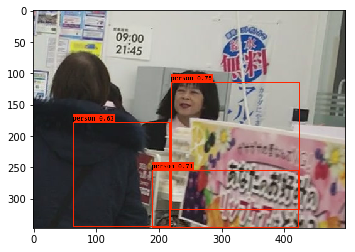

(array([0.74912834, 0.714647  , 0.6299559 ], dtype=float32),
 array([[113.53374, 218.8086 , 316.65463, 424.15714],
        [253.81862, 188.74493, 413.71753, 422.55966],
        [178.29808,  62.63718, 344.79028, 217.95328]], dtype=float32),
 array([0, 0, 0]))

In [2]:
predict("Images/000/0001.JPEG")

[array([[153.17043 ,  41.532   , 309.55362 , 167.26015 ],
       [115.872375, 194.2754  , 281.91364 , 405.98557 ]], dtype=float32), array([0.6653651, 0.6030176], dtype=float32), array([0, 0])]
Found 2 boxes for Images/000/0002.JPEG
person 0.60 (194, 116) (406, 282)
person 0.67 (42, 153) (167, 304)


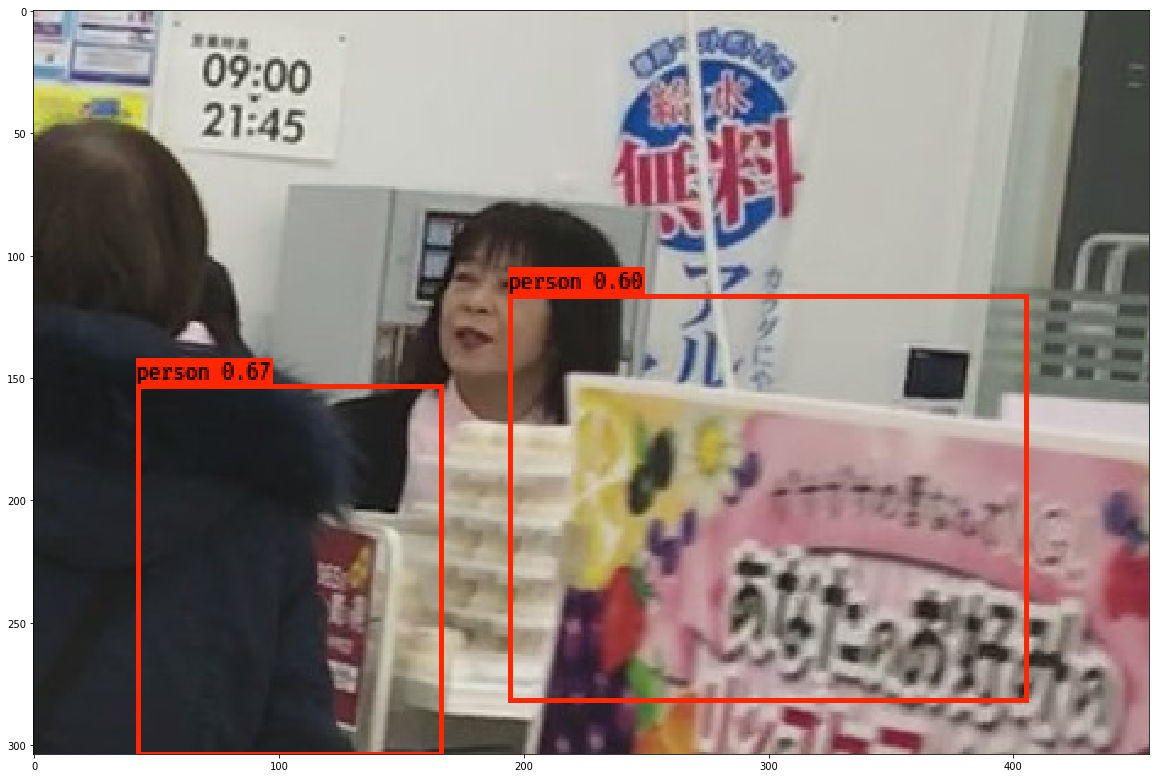

(array([0.6653651, 0.6030176], dtype=float32),
 array([[153.17043 ,  41.532   , 309.55362 , 167.26015 ],
        [115.872375, 194.2754  , 281.91364 , 405.98557 ]], dtype=float32),
 array([0, 0]))

In [3]:
predict("Images/000/0002.JPEG")

[array([], shape=(0, 4), dtype=float32), array([], dtype=float32), array([], dtype=int64)]
Found 0 boxes for Images/000/0003.JPEG


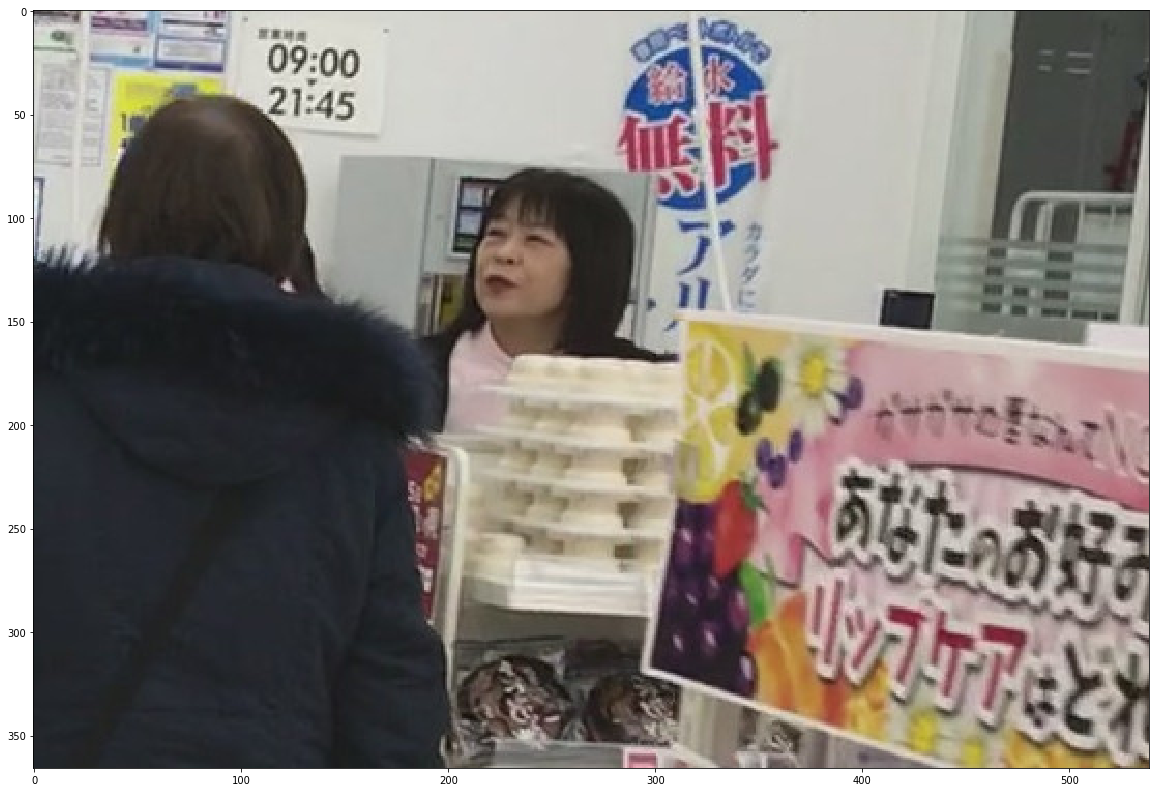

(array([], dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], dtype=int64))

In [4]:
predict("Images/000/0003.JPEG")

[array([[ -5.3123903,  53.979465 , 330.15845  , 247.10245  ],
       [  7.9016304, 257.56937  , 263.61487  , 362.14438  ]],
      dtype=float32), array([0.8138594, 0.6517422], dtype=float32), array([0, 0])]
Found 2 boxes for Images/000/0363.JPEG
person 0.65 (258, 8) (362, 264)
person 0.81 (54, 0) (247, 330)


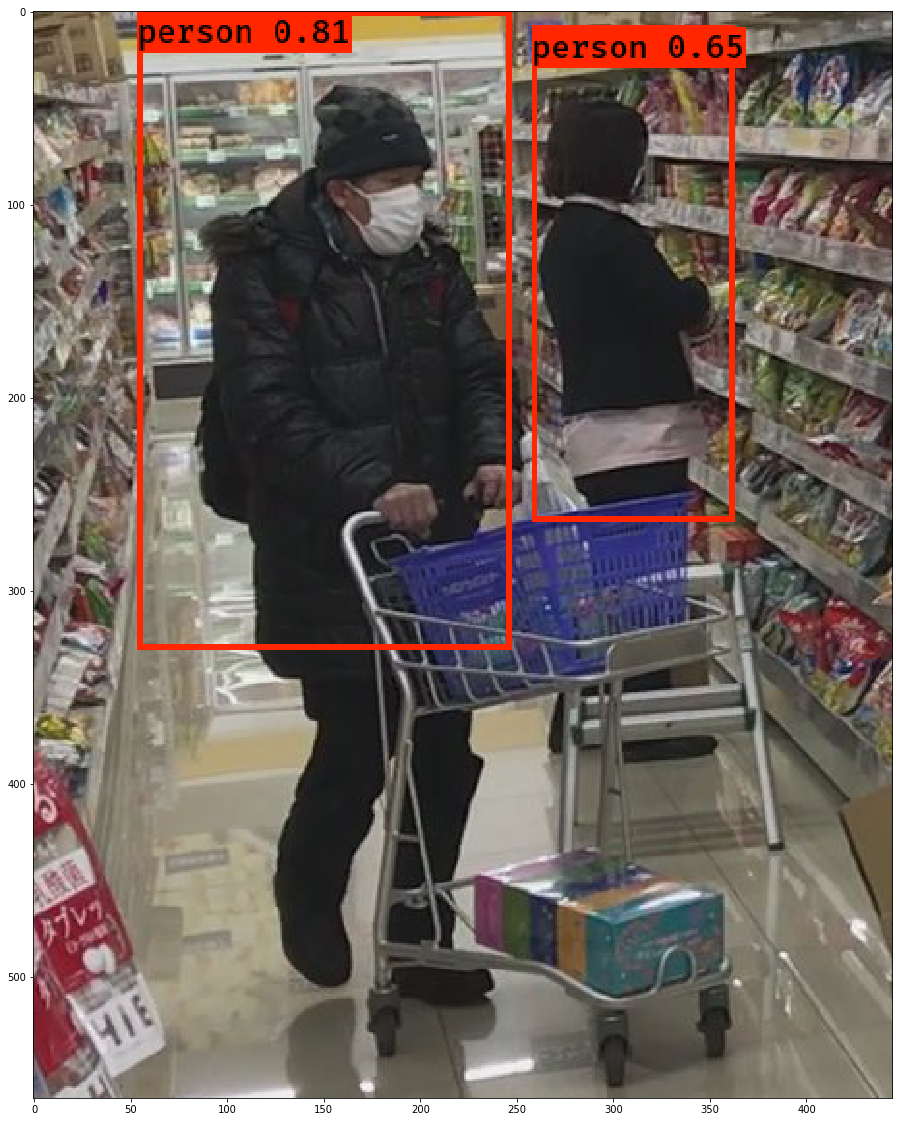

(array([0.8138594, 0.6517422], dtype=float32),
 array([[ -5.3123903,  53.979465 , 330.15845  , 247.10245  ],
        [  7.9016304, 257.56937  , 263.61487  , 362.14438  ]],
       dtype=float32),
 array([0, 0]))

In [5]:
predict("Images/000/0363.JPEG")

[array([[146.87268  ,  -2.8094482, 356.70358  , 229.42368  ],
       [269.74954  ,  68.91368  , 374.8176   , 173.40285  ]],
      dtype=float32), array([0.68379104, 0.61702543], dtype=float32), array([0, 0])]
Found 2 boxes for images/person.jpg
person 0.62 (69, 270) (173, 375)
person 0.68 (0, 147) (229, 357)


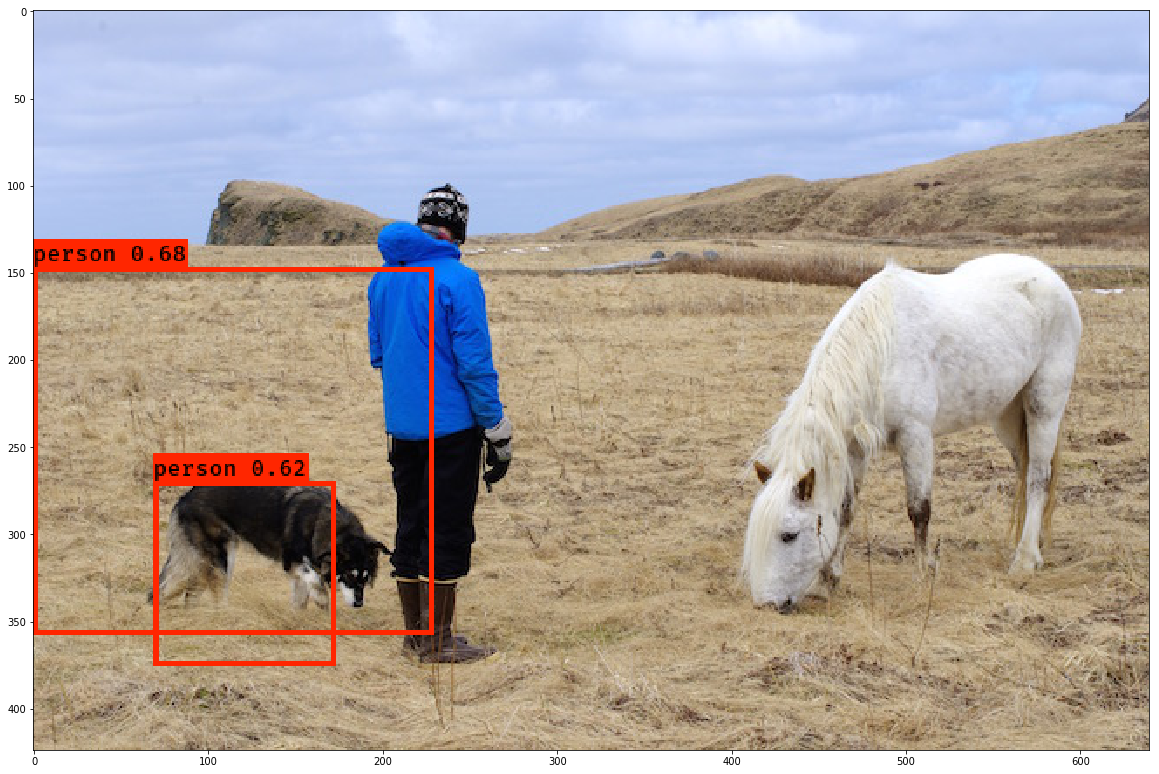

(array([0.68379104, 0.61702543], dtype=float32),
 array([[146.87268  ,  -2.8094482, 356.70358  , 229.42368  ],
        [269.74954  ,  68.91368  , 374.8176   , 173.40285  ]],
       dtype=float32),
 array([0, 0]))

In [6]:
predict("images/person.jpg")